In [3]:
import gym
from gym import wrappers

# from __future__ import annotations

from collections import defaultdict
from typing import Tuple, List

import numpy as np
from IPython import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [9]:
class agent:
    rewards = []
    errors = []
    episode = 0
    
    def update(self):
        pass

    def get_action(self):
        pass

    def anneal_epsilon(self, min_epsilon=0.01, max_epsilon=0.1, decay_rate=0.01):
        self.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * self.episode)

    def moving_average(self, x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    
    def plot(self):
        fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
        axs[0].set_title("Average Reward")
        axs[0].plot(list(range(len(self.moving_average(self.rewards,500)))),self.moving_average(self.rewards,500))

        axs[1].set_title("Temporal diff error")
        axs[1].plot(list(range(len(self.moving_average(self.errors,500)))),self.moving_average(self.errors,500))

        plt.tight_layout()
        plt.show()

class MonteCarloAgent(agent):

    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.returns = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.visit_counts = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.episode = 0

    def update(self, episode_history: List[Tuple[Tuple[int, int, bool], int, int]]) -> None:
        self.episode += 1
        G = 0
        visited_states = set()

        for t in reversed(range(len(episode_history))):
            state, action, reward = episode_history[t]
            G = self.gamma * G + reward

            if (state, action) not in visited_states:
                visited_states.add((state, action))
                self.visit_counts[state][action] += 1
                self.returns[state][action] += G
                #update in the stationary distribution
                # self.q_table[state][action] = self.returns[state][action] / self.visit_counts[state][action]

                error = self.alpha * (G - self.q_table[state][action])
                self.q_table[state][action] += error

                self.errors.append(error)

        self.anneal_epsilon()

    def get_action(self, state: Tuple[int, int, bool]) -> int:
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def get_q_table(self):
        return self.q_table


In [10]:


num_episodes = 100_000
env = gym.make('Blackjack-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=num_episodes)
mc_agent = MonteCarloAgent(env, gamma=0.95, epsilon=0.1)
for _ in range(num_episodes):
    state, trunc = env.reset()
    done = False
    episode_history = []

    while not done:
        action = mc_agent.get_action(state)
        next_state, reward, done, _, info = env.step(action)
        episode_history.append((state, action, reward))
        state = next_state

    mc_agent.update(episode_history)
    mc_agent.rewards.append(reward)


/mnt/c/Users/user/Documents/openai_gym_projects/gym/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


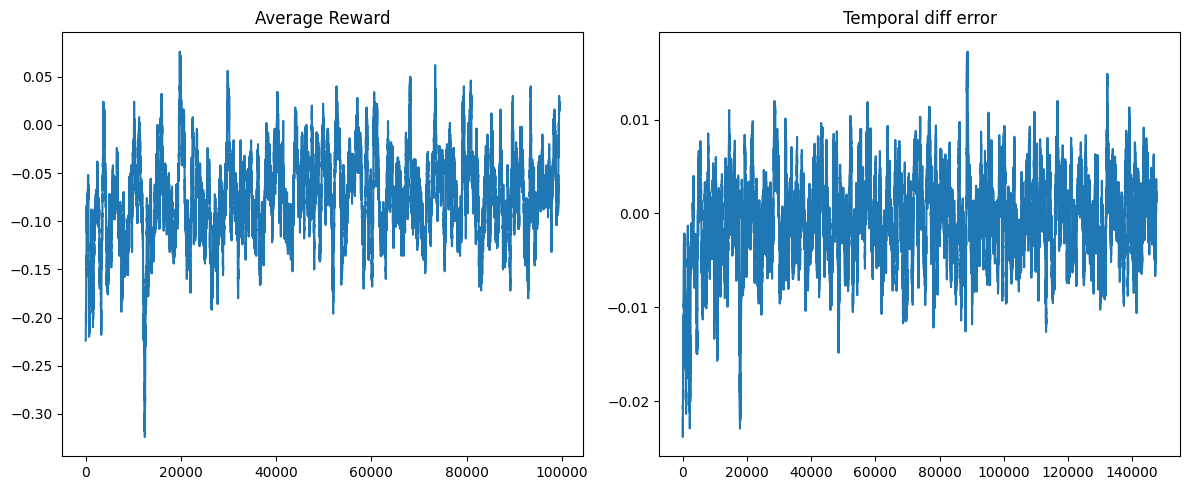

In [11]:
mc_agent.plot()